# An example of using candex with source netCDF files in irregualr shape 
## Remapping of SCDNA to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [1]:
# download SCDNA data and convert it to Xarray-based format

import xarray as xr
import urllib.request
import numpy as np
import pandas as pd
import os
from datetime import datetime
import time

pwd = '/Users/shg096/Desktop/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'
fname = 'SCDNA_v1.1.nc'

def download_process_SCDNA(pwd, filename):
    
    if not os.path.isdir(pwd):
        os.mkdir(pwd)
    
    # remove existing file is exists
    outfile = pwd+filename
    if os.path.isfile(outfile):
        print('It seems the file exists; perhaps perviously downloaded; will skip downloading')
    else:
        # download the file
        print('Downloading SCDNA; this may take a while ...')
        print('Downloading starts at: ', datetime.now())
        url = 'http://zenodo.org/record/3953310/files/SCDNA_v1.1.nc4?download=1'
        urllib.request.urlretrieve(url, outfile)
        print('Downloading ends at: ', datetime.now())
    
    if not os.path.isdir(pwd+'/prcp/'):
        os.mkdir (pwd+'/prcp/')
    if not os.path.isdir(pwd+'/tmin/'):
        os.mkdir (pwd+'/tmin/')
    if not os.path.isdir(pwd+'/tmax/'):
        os.mkdir (pwd+'/tmax/')
    
    print('Formatting SCDNA ...')
    print('Formatting starts at: ', datetime.now())
    ds         = xr.open_dataset(outfile)
    ds         = ds.load()
    nstn       = ds.LLE.shape[1] # number of stations
    ds         = ds.rename({'nstn':'stn','nday':'time'}) # renaming
    ds['stn']  = np.arange(nstn) + 1 # ID of stations from 1 to the number of stations
    ds['time'] = pd.date_range(start=str(ds.date[0].values),\
                               end=str(ds.date[-1].values),freq='1D') # time
    ds         = ds.set_coords('stn') # set stn as coordinate
    ds         = ds.set_coords('time') # set time as coordinate
    ds['lat']  = ds.LLE[0, :] # pass lat values to a new variable
    ds['lon']  = ds.LLE[1, :] # pass lon values to a new variable
    ds['elev'] = ds.LLE[2, :] # pass elevation values to a new variable
    
    # get the sart and end year
    start_year = int(str(ds.date[0].values)[0:4])
    end_year   = int(str(ds.date[-1].values)[0:4])
    years      = list (np.arange(start_year, end_year+1))
    
    # drop the varibales
    ds = ds.drop(['ID','LLE', 'date', 'sflag', 'prcp_flag', 'prcp_kge',\
                  'tmin_flag', 'tmin_kge', 'tmax_flag', 'tmax_kge'])
    
    # subset based on prec, tmin or tmax
    temp          = ds['prcp'].isel(time=0).values
    stnvalidprcp  = np.where(~np.isnan(temp))[0]
    print('Number of stations with precipitation data: ', len(stnvalidprcp))

    temp          = ds['tmin'].isel(time=0).values
    stnvalidtmin  = np.where(~np.isnan(temp))[0]
    print('Number of stations with minimum temprature data: ', len(stnvalidtmin))

    temp          = ds['tmax'].isel(time=0).values
    stnvalidtmax  = np.where(~np.isnan(temp))[0]
    print('Number of stations with maximum temprature data: ', len(stnvalidtmax))
    
    #
    print('Formatting ends at: ', datetime.now())
    
    #
    print('Slicing SCDNA and saving it in yearly files ...')
    print('Slicing starts at: ', datetime.now())
    
    for year in years:
        year_str = str(year)
        print(year_str)
        outfile = pwd+'/SCDNA_v1.1.'+year_str+'.nc'
        temp = ds.sel(time=slice(year_str,year_str)) # slice for time\        
        if os.path.isfile (outfile):
            os.remove(outfile)
        temp.to_netcdf(outfile)
        # print ('Yearly SCDNA file is saved for '+year_str+' at '+ outfile)
        
        # reload the file
        #temp = xr.open_dataset(outfile)

        # precipitation
        temp_prcp = temp.drop(['tmin', 'tmax'])
        temp_prcp = temp_prcp.isel(stn=stnvalidprcp)
        outfile_prcp = pwd+'/prcp/SCDNA_v1.1.prcp.'+year_str+'.nc'
        if os.path.isfile (outfile_prcp):
            os.remove(outfile_prcp)
        temp_prcp.to_netcdf(outfile_prcp)
        #print ('Yearly SCDNA precipitation file is saved for '+year_str+' at '+ outfile_prcp)

        # tmin
        temp_tmin = temp.drop(['prcp', 'tmax'])
        temp_tmin = temp_tmin.isel(stn=stnvalidtmin)
        outfile_tmin = pwd+'/tmin/SCDNA_v1.1.tmin.'+year_str+'.nc'
        if os.path.isfile (outfile_tmin):
            os.remove(outfile_tmin)
        temp_tmin.to_netcdf(outfile_tmin)
        #print ('Yearly SCDNA minimum temperature file is saved for '+year_str+' at '+ outfile_tmin)

        # tmax
        temp_tmax = temp.drop(['prcp', 'tmin'])
        temp_tmax = temp_tmax.isel(stn=stnvalidtmax)
        outfile_tmax = pwd+'/tmax/SCDNA_v1.1.tmax.'+year_str+'.nc'
        if os.path.isfile (outfile_tmax):
            os.remove(outfile_tmax)
        temp_tmax.to_netcdf(outfile_tmax)
        #print ('Yearly SCDNA maximum temperature file is saved for '+year_str+' at '+ outfile_tmax)
        
        # remove the file
        os.remove (outfile)
        
    print('Slicing ends at: ', datetime.now())
        
    
# call the function
download_process_SCDNA(pwd, fname)



It seems the file exists; perhaps perviously downloaded; will skip downloading
Formatting SCDNA ...
Formatting starts at:  2021-02-17 20:30:43.451890
Number of stations with precipitation data:  24615
Number of stations with minimum temprature data:  19604
Number of stations with maximum temprature data:  19611
Formatting ends at:  2021-02-17 20:31:48.688537
Slicing SCDNA and saving it in yearly files ...
Slicing starts at:  2021-02-17 20:31:48.688647
1979
1980
1981
Slicing ends at:  2021-02-17 20:34:02.302326


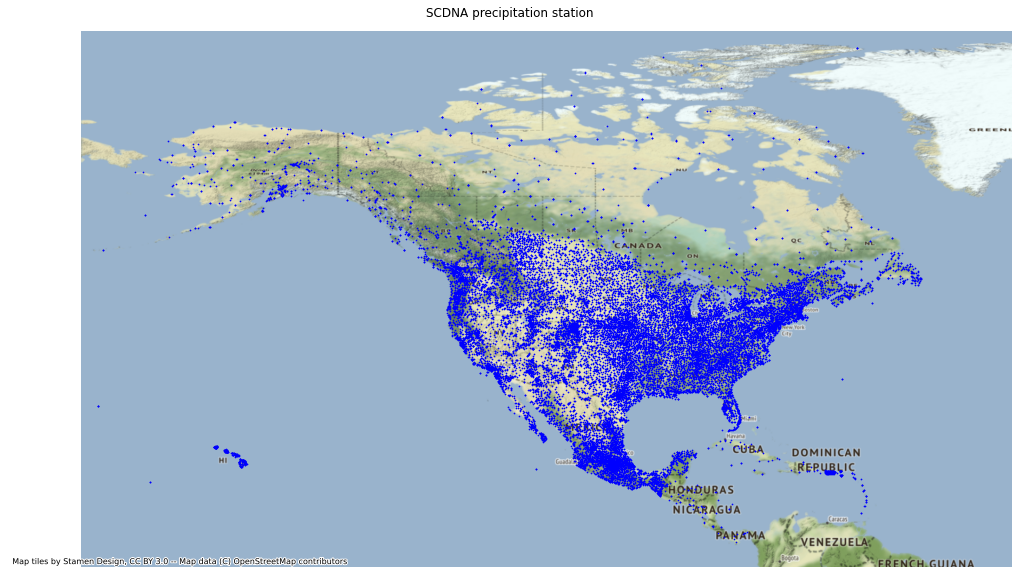

In [2]:
import xarray as xr
import pandas as pd
from   shapely.geometry import Point
import geopandas as gpd


pwd = '/Users/shg096/Desktop/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'

infile_prcp  = pwd+'/prcp/SCDNA_v1.1.prcp.1979.nc'
outfile_prcp = pwd+'/prcp/SCDNA.prcp.gpkg'

infile_tmin  = pwd+'/tmin/SCDNA_v1.1.tmin.1979.nc'
outfile_tmin = pwd+'/tmin/SCDNA.tmin.gpkg'

infile_tmax  = pwd+'/tmax/SCDNA_v1.1.tmax.1979.nc'
outfile_tmax = pwd+'/tmax/SCDNA.tmax.gpkg'


def create_shp_SCDNA(infile, outfile):
    
    # load one the yearly nc files
    ds = xr.open_dataset(infile)
    
    nstn = ds.lat.shape[0] # number of stations

    points = pd.DataFrame()
    points['LATITUDE']  = ds.lat[:]
    points['LONGITUDE'] = ds.lon[:]
    points['ID']        = ds.stn[:]

    # the columns of the DataFrame
    points['geometry'] = points.apply(lambda row: Point(row.LONGITUDE, row.LATITUDE ), axis=1) # set the geometry
    points  = gpd.GeoDataFrame(points) # pass this to a geopandas dataframe
    points = points.set_crs("EPSG:4326") # set the projection to WGS 1984
    points.to_file(outfile)
    
create_shp_SCDNA(infile_prcp, outfile_prcp)
create_shp_SCDNA(infile_tmin, outfile_tmin)
create_shp_SCDNA(infile_tmax, outfile_tmax)



## visualizing the point shapefiles for precipitation stations
import contextily as ctx
import matplotlib.pyplot as plt

stations = gpd.read_file(outfile_prcp)

fig, ax = plt.subplots(figsize=(18, 10))
stations.plot(ax=ax, color='blue', markersize = 0.5)
ax.axis('off')
plt.axis('equal')
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
plt.title ('SCDNA precipitation station')
plt.show()


<ipython-input-3-70883a1b6c64>:23: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile


Text(0.5, 1.0, 'SCDNA Voronoi [Thiessen] diagram for SCDNA minimum temperature stations')

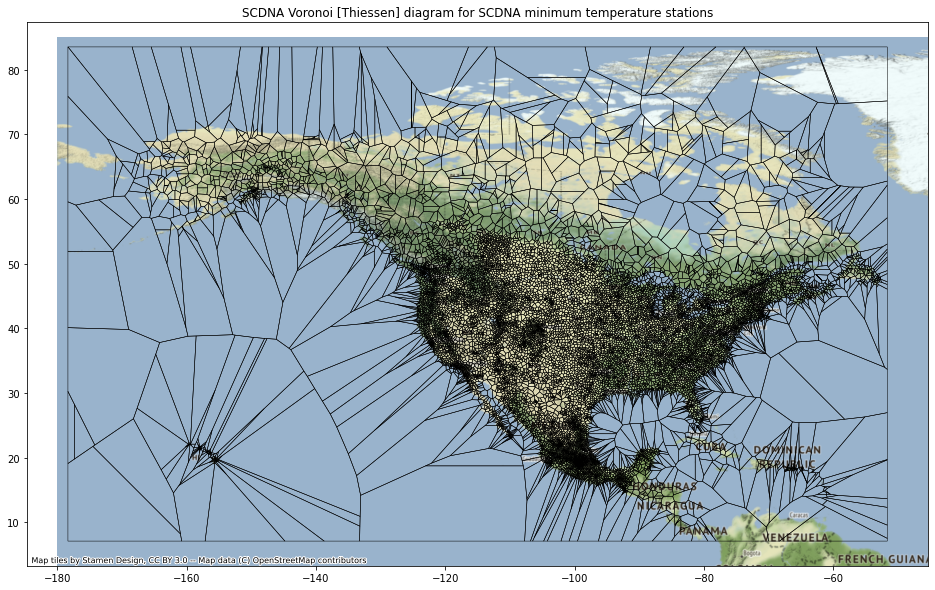

In [3]:
import shapefile
import geovoronoi
import os
from   shapely.geometry import Polygon
import numpy as np

infile_prcp  = pwd+'/prcp/SCDNA.prcp.gpkg'
outfile_prcp = pwd+'/prcp/SCDNA.prcp.voronoi.gpkg'

infile_tmin  = pwd+'/tmin/SCDNA.tmin.gpkg'
outfile_tmin = pwd+'/tmin/SCDNA.tmin.voronoi.gpkg'

infile_tmax  = pwd+'/tmax/SCDNA.tmax.gpkg'
outfile_tmax = pwd+'/tmax/SCDNA.tmax.voronoi.gpkg'


def voronoi_diagram(infile, outfile): # infile a point shapefile, outfile a shapefile
    
    # read the shapefile
    stations = gpd.read_file(infile)
    
    # get the total boundary of the shapefile
    stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile
    minx, miny, maxx, maxy = stations_buffert.total_bounds
    
    # create the bounding shapefile
    parts = []
    with shapefile.Writer('test.shp') as w:
        w.autoBalance = 1 # turn on function that keeps file stable if number of shapes and records don't line up
        w.field("ID_bounding",'N') # create (N)umerical attribute fields, integer

        # creating the polygon given the lat and lon
        parts.append([ (minx, miny),\
                       (minx, maxy), \
                       (maxx, maxy), \
                       (maxx, miny), \
                       (minx, miny)])

        # store polygon
        w.poly(parts)

        # update records/fields for the polygon
        w.record(1)

    boundary = gpd.read_file('test.shp')
    os.remove('test.shp')
    
    # create the voroni diagram for given point shapefile
    coords = geovoronoi.points_to_coords(stations.geometry)

    poly_shapes, location = \
    geovoronoi.voronoi_regions_from_coords(coords, boundary.iloc[0].geometry)
    
    
    # pass te polygons to shapefile
    Thiessen = gpd.GeoDataFrame()
    Thiessen['geometry'] = None
    Thiessen['ID'] = None
    Thiessen['LATITUDE'] = None
    Thiessen['LONGITUDE'] = None


    for i in np.arange(len(poly_shapes)):
        Thiessen.loc[i, 'geometry'] = Polygon(poly_shapes[i])
        Thiessen.loc[i, 'ID']       = stations.iloc[location[i][0]].ID.astype(float)
        Thiessen.loc[i, 'LATITUDE'] = stations.iloc[location[i][0]].LATITUDE.astype(float)
        Thiessen.loc[i, 'LONGITUDE']= stations.iloc[location[i][0]].LONGITUDE.astype(float)
    
    Thiessen = Thiessen.set_crs("EPSG:4326")

    Thiessen.to_file(outfile)
    
voronoi_diagram(infile_prcp, outfile_prcp)
voronoi_diagram(infile_tmin, outfile_tmin)
voronoi_diagram(infile_tmax, outfile_tmax)

## visualization of voronoi diagram for precipitation stations
shp = gpd.read_file(outfile_tmin)
fig, ax = plt.subplots(figsize=(18, 10))
shp.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.5 , figsize=(15,30),ax=ax)
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
plt.title('SCDNA Voronoi [Thiessen] diagram for SCDNA minimum temperature stations')


Text(0.5, 1.0, 'SCDNA precipitation')

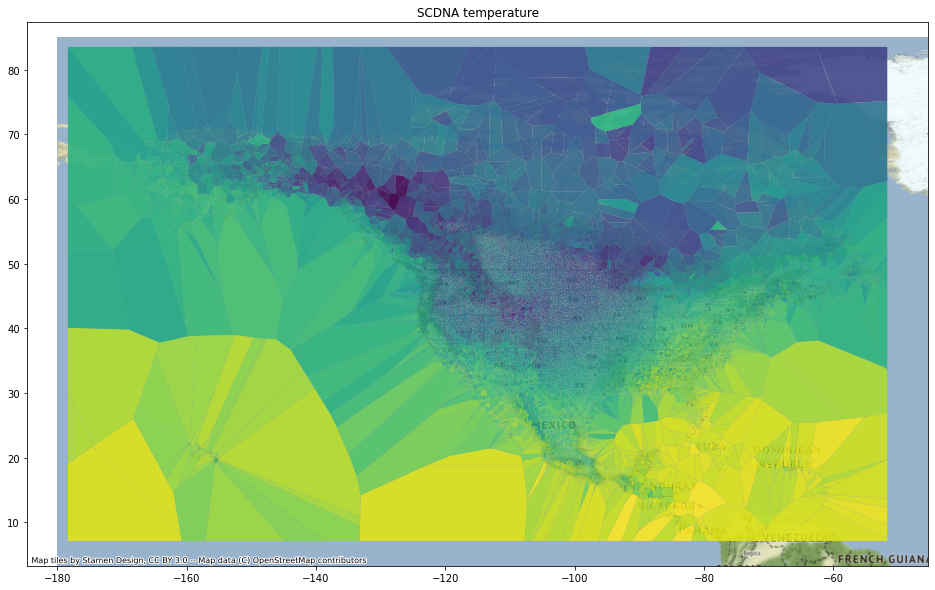

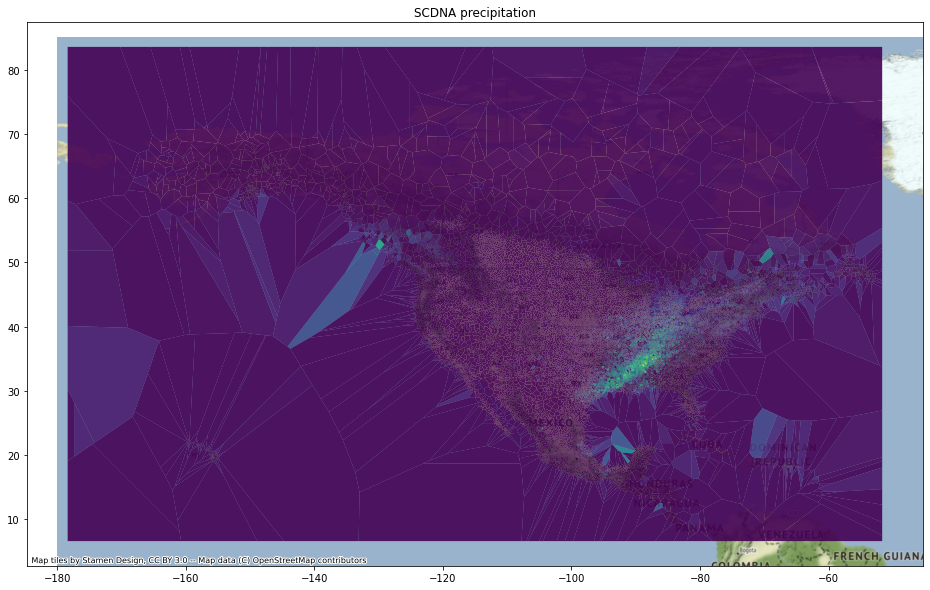

In [4]:
# visualize the voronoi diagram with data from SCDNA

voronoi_prcp = pwd+'/tmin/SCDNA.tmin.voronoi.gpkg'
infile_prcp  = pwd+'/tmin/SCDNA_v1.1.tmin.1979.nc'

#
Thiessen = gpd.read_file(voronoi_prcp)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
ds = xr.open_dataset(infile_prcp)
df = pd.DataFrame()
df ['values']     = ds.tmin.sel(time='1979-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)
df = df.sort_values(by='ID')# sort on values

# merge based on ID
Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.title('SCDNA temperature')



# visualize the voronoi diagram with data from SCDNA
voronoi_prcp = pwd+'/prcp/SCDNA.prcp.voronoi.gpkg'
infile_prcp  = pwd+'/prcp/SCDNA_v1.1.prcp.1979.nc'

#
Thiessen = gpd.read_file(voronoi_prcp)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
ds = xr.open_dataset(infile_prcp)
df = pd.DataFrame()
df ['values']     = ds.prcp.sel(time='1979-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)
df = df.sort_values(by='ID')# sort on values

# merge based on ID
Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.title('SCDNA precipitation')


In [ ]:
# loading candex
from candex.candex import candex

# initializing candex object
cndx = candex()

# specifying candex needed arguments
cndx.name_of_case             = 'SCDNA_Medicine_Hat' # name of the case
cndx.temporary_candex_folder  = '../temporary/' # temporary path that the candex generated GIS files and rempped file will be saved
cndx.name_of_target_shp       = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp' # target shapefile that the source will be remmaped to
cndx.name_of_nc_files         = '/Users/shg096/Desktop/SCDNA/tmin/SCDNA_*.nc' # name of netCDF file(s) if multiple you can specify with *
cndx.name_of_var_name         = ['tmin'] # name of variables from source netCDF file(s) to be remapped
cndx.name_of_var_lon          = 'lon' # name of varibale longitude in source netCDF files 
cndx.name_of_var_lat          = 'lat' # name of variable latitude in source netCDF files
cndx.name_of_var_time         = 'time' # name of varibale time in source netCDF file
cndx.name_of_shp_for_nc_files = '/Users/shg096/Desktop/SCDNA/tmin/SCDNA.tmin.voronoi.gpkg'
cndx.name_of_field_target_lat_shp_for_nc_files  =  'LATITUDE' # name_of_nc_files
cndx.name_of_field_target_lon_shp_for_nc_files  =  'LONGITUDE'
cndx.name_of_nc_output_folder = '../output/' # location where the remapped netCDF file will be saved
cndx.format_list              =  ['f4']#,'f4'] # format of the varibales to be saved with
cndx.fill_value_list          = ['-9999.00']#,'-9999.00'] # missing values for the varibales
# cndx.name_of_remap_file        = '../temporary/ERA5_Medicine_Hat_remapping.csv' # if uncommneted candex will use this and skip GIS taskes

# execute candex
cndx.run_candex()



no  author name is provide and the author name is changes to (author name)!
candex detects that target shapefile is in WGS84 (epsg:4326)
candex detects that no fields are provided for ID, lat, lon and will assign those by itself
candex will save standard shapefile for candex claculation as:
../temporary/SCDNA_Medicine_Hat_target_shapefile.shp


/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/candex/candex.py:139: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lat_t'] = shp.centroid.y # centroid lat from target
/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/candex/candex.py:140: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lon_t'] = shp.centroid.x # centroid lon from target


candex detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
candex detects that all the varibales have dimensions of:
['stn', 'time']
candex detects that the longitude varibales has dimensions of:
['stn']
candex detects that the latitude varibales has dimensions of:
['stn']
candex detects case 3 - irregular lat/lon; shapefile should be provided
[48.94   48.52   48.82   ... 20.9625 47.5083 21.3167] [-123.74   -123.37   -124.13   ... -156.6753 -115.9461 -158.0667]
candex detects that no varibale for ID of the source netCDF file; an arbitatiry ID will be provided
candex decides the netCDF file has longtitude values of -180 to 180; creating the extended
candex saved the expanded shapefile at:
../temporary/SCDNA_Medicine_Hat_source_shapefile_expanded.shp
candex detects that source shapefile is in WGS84 (epsg:4326)
checking latitude and longitude values from source shapefile and nc file
this may take a while
progress:  0.0
pr

In [ ]:
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx



ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1979.nc')
Thiessen = gpd.read_file('/Users/shg096/Desktop/SCDNA/tmin/SCDNA.tmin.voronoi.gpkg')
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')
shp_target = gpd.read_file(cndx.temporary_candex_folder+ cndx.name_of_case +\
                           '_target_shapefile.shp') # load the target shapefile
shp_target = shp_target.sort_values(by='ID_t')


#
df = pd.DataFrame()
df ['values']     = ds.tmin.sel(time='1979-01-10')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)


df = df.dropna() # drop the values that are NaN
df = df.sort_values(by='ID')# sort on values

Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, vmin=-40, vmax = -10)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-117, -110])
plt.ylim([  48,   52])
shp_target.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax)


## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, vmin=-40, vmax = -10)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-117, -110])
plt.ylim([  48,   52])

ds2 = xr.open_dataset('../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc')

shp_target ['values'] = ds2.tmin.sel(time='1979-01-10')

shp_target.plot(column='values', edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax, vmin=-40, vmax = -10)
